In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from scipy.optimize import root
from numba import jit

from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib.colors import Normalize


kcant =  10
l0 = 200
xi = 0.5
tr = 0.2
lp = 50
K = 1100
L = 300
kT = 4.1
mu = 2./kT
etaH2O = 0.89
aeff = 25000
heff = 5000
tf = 2.
dt = 10**-4
steps = int(tf/dt)
dU0 = 25
yB = 1.
ycusp = yB/2
dU = 16*dU0/yB**4.
beta = 1/4.1
k0, d = .1*10**-3, .4

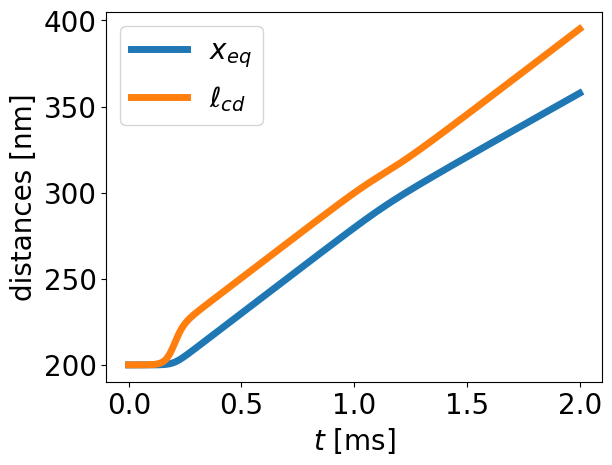

In [2]:
xeq = np.genfromtxt('xeq.csv', delimiter=',')
lamcd = np.genfromtxt('lamcdtab.csv', delimiter=',')
plt.plot(np.linspace(0., tf, len(xeq)), xeq, label=r'$x_{eq}$', linewidth=5)

# Plot the second line (lamcd)
plt.plot(np.linspace(0., tf, len(lamcd)), lamcd, label=r'$\ell_{cd}$', linewidth=5)

# Add labels and title
plt.xlabel(r'$t$ [ms]', fontsize=20)
plt.ylabel('distances [nm]', fontsize=20)
# plt.title('Plot of $x_{eq}$ and $\ell_{cd}$', fontsize=20)
custom_ticks = np.arange(0.0, 2.1, 0.5)
custom_ticksy = np.arange(200,410, 50)
plt.xticks(custom_ticks)
# Set the font size of ticks
plt.yticks(custom_ticksy)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Show legend with fontsize 15
plt.legend(fontsize=20)

# Show plot
plt.show()

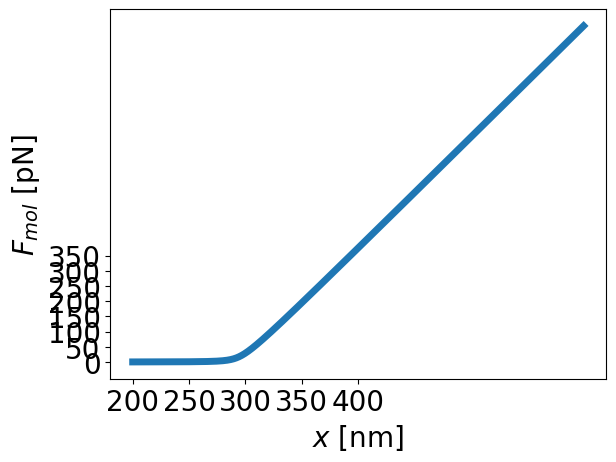

In [3]:
xtab = np.linspace(200,600,20000)
Fmol = []
Fmol0 = 0.
for i in range(len(xtab)):
    x = xtab[i]
    def func(Fx):
        return Fx - kT/lp*(.25/(1-x/L+Fx/K)**2.-.25+x/L-Fx/K)
    if i == 0:
        sol = root(func, Fmol0)
    else:
        sol = root(func, Fmol[-1])
    Fmol.append(sol.x[0])
    

plt.plot(xtab, Fmol, label=r'$F_eq$', linewidth=5)

# Plot the second line (lamcd)
# plt.plot(np.linspace(0., tf, len(lamcd)), lamcd, label=r'$\ell_{cd}$', linewidth=5)

# Add labels and title
plt.xlabel(r'$x$ [nm]', fontsize=20)
plt.ylabel(r'$F_{mol}$ [pN]', fontsize=20)
# plt.title('Plot of $x_{eq}$ and $\ell_{cd}$', fontsize=20)
custom_ticks = np.arange(200,410, 50)
custom_ticksy = np.arange(0,400, 50)
plt.xticks(custom_ticks)
# Set the font size of ticks
plt.yticks(custom_ticksy)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()
# Show legend with fontsize 15
# plt.legend(fontsize=15)


    

In [4]:
n_beads, k, sig_LJ, eps_LJ = 20, 5.0, 1.0, 40.
r_cusp = 2.5
dt = 1*10**-4
@jit(nopython=True)
def Fp(y):
    Fb = np.zeros((n_beads,3))
    Fb[0] = -k*(y[0]-y[1])
#     Fb[0] = [0.,0.,0.]
    for i in range(1, n_beads-1):
        Fb[i] = -k*(2*y[i]-y[i+1]-y[i-1])
    Fb[-1] = -k*(y[-1]-y[-2])
    
    R2 = np.sum((y[-1]-y[0])**2.)
    F_LJ = 4*eps_LJ*(12*sig_LJ**12 / R2**7 - 6*sig_LJ**6 / R2**4)*(y[-1]-y[0])
    
    Fpoly = Fb
    Fpoly[0] = Fpoly[0] - F_LJ
    Fpoly[-1] = Fpoly[-1] + F_LJ
    return Fpoly

@jit(nopython=True)
def trajpoly(samples, freq, seed):
    count  = 0
    rmin = 2**(1/6)*sig_LJ
    np.random.seed(seed)
    stepsp = 2*10**6
    y  = np.zeros((n_beads, 3))
    yt = np.zeros((samples,n_beads, 3 ))
    for i in range(int(n_beads/2)):
        y[i] = [0.,0.,i*rmin*1.1]
        y[-i] = [rmin, rmin, i*rmin*1.1]
        
    for i in range(10**5):
        Fpoly = Fp(y)
        noise = np.random.randn(n_beads,3)
        y = y + dt*Fpoly*mu +  (2*2.*dt)**.5*noise
        
    for i in range(samples*freq):
        Fpoly = Fp(y)
        noise = np.random.randn(n_beads,3)
        y = y + dt*Fpoly*mu +  (2*2.*dt)**.5*noise
        if i%freq == 0:
            print(count)
            yt[count] = y
            count += 1

    return yt

samples = 2500
freq = 2*10**5
y0tab = trajpoly(samples, freq, 38736)
np.save('y0tab_polymer', y0tab)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062


975

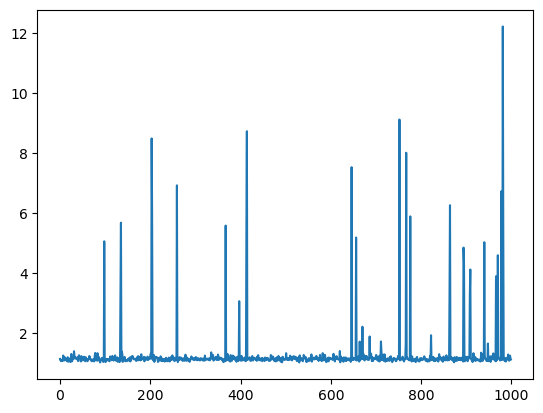

In [7]:
rt = []
for i in range(len(y0tab)):
    yi =  y0tab[i]
    rt.append((np.sum((yi[-1]-yi[0])**2.))**.5)
plt.plot(rt)
rt = np.asarray(rt)
len(y0tab[rt< 3*2**(1/6)])

v =  95
Regular pulling
CD pulling
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268

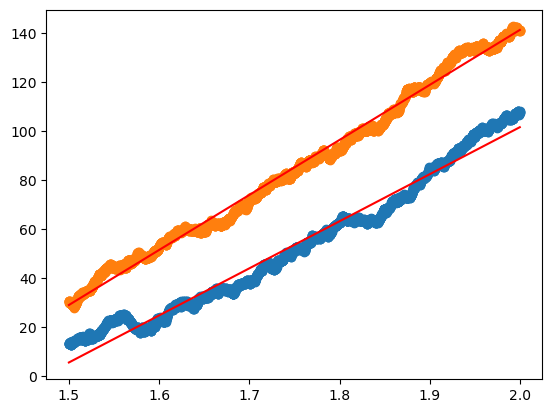

getting equilibrium trajs
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270


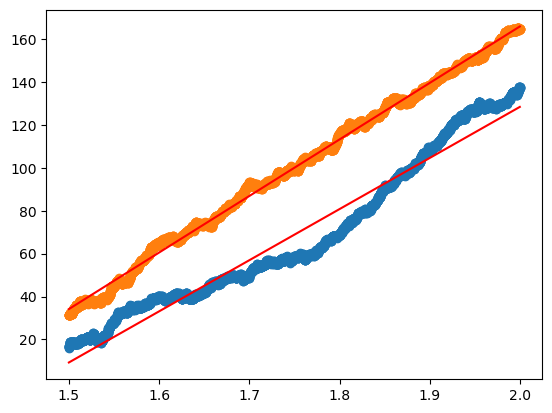

getting equilibrium trajs
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270


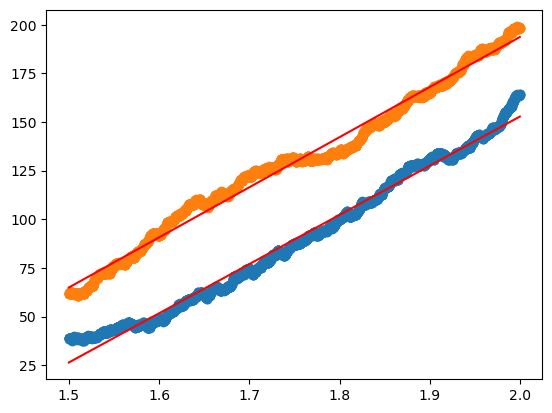

getting equilibrium trajs
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270


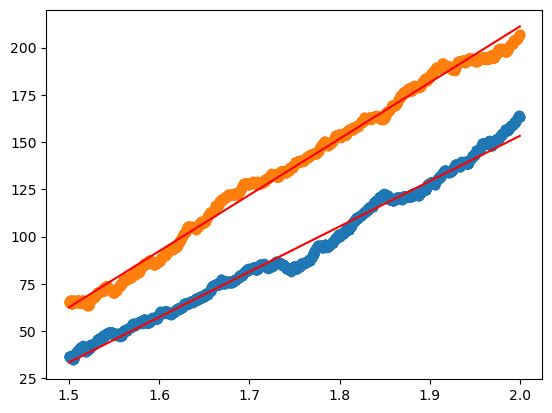

getting equilibrium trajs
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270


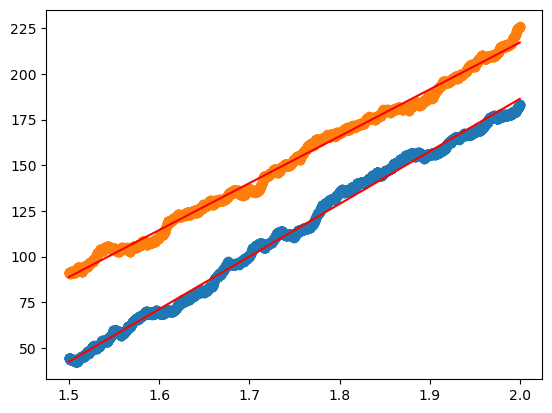

getting equilibrium trajs
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270


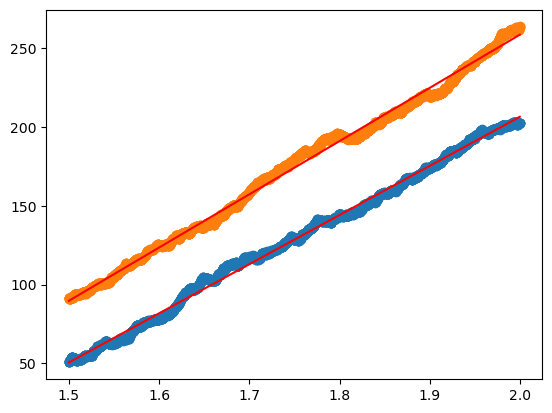

getting equilibrium trajs
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270


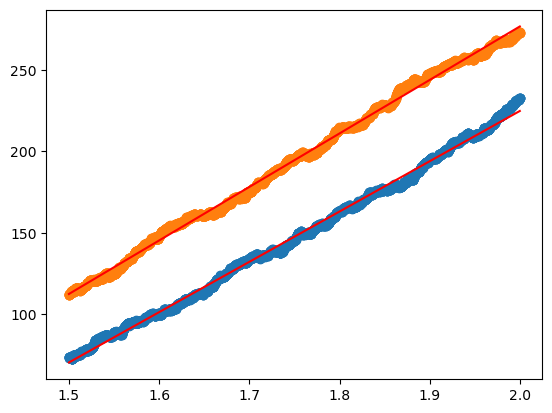

getting equilibrium trajs
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270


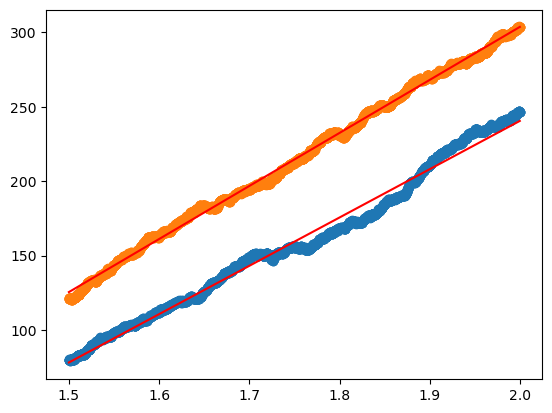

getting equilibrium trajs
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270


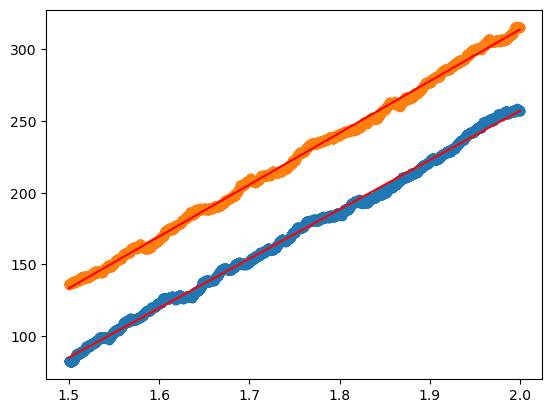

getting equilibrium trajs
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270


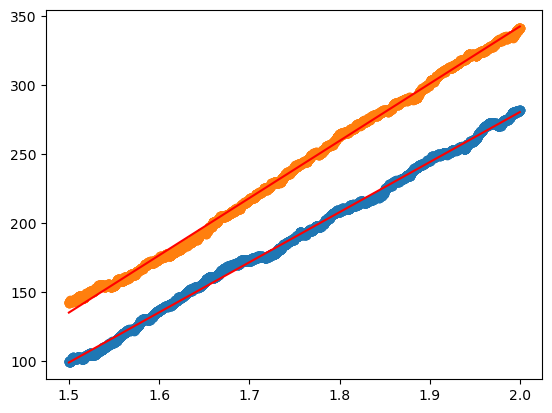

getting equilibrium trajs
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270


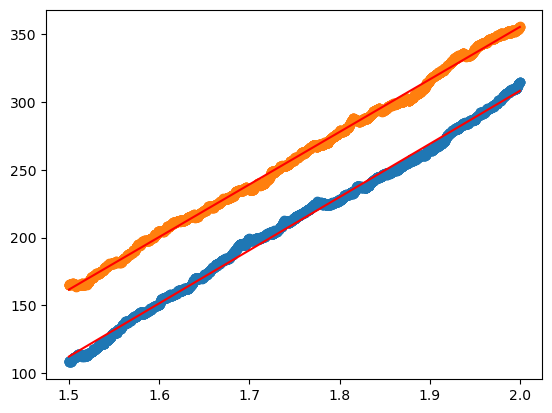

getting equilibrium trajs
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270


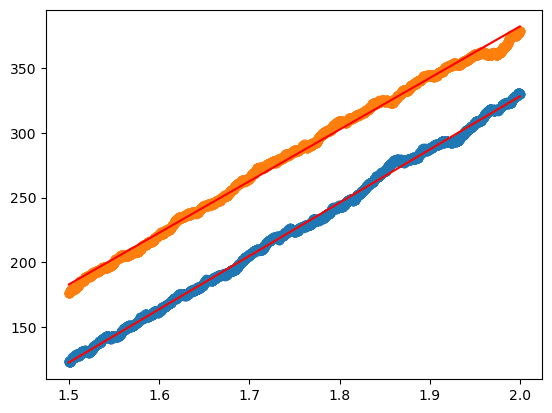

getting equilibrium trajs
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270


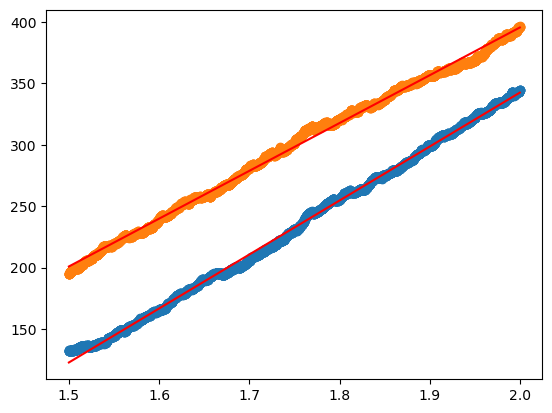

getting equilibrium trajs
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270


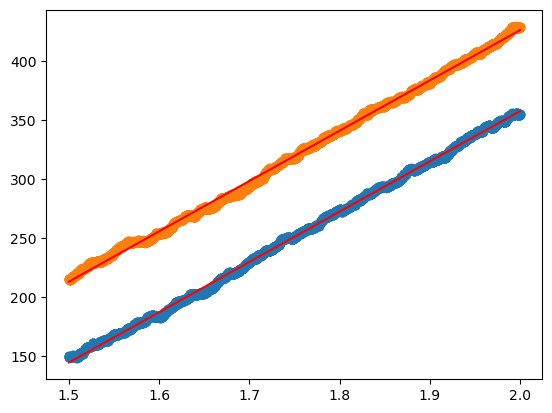

getting equilibrium trajs
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270


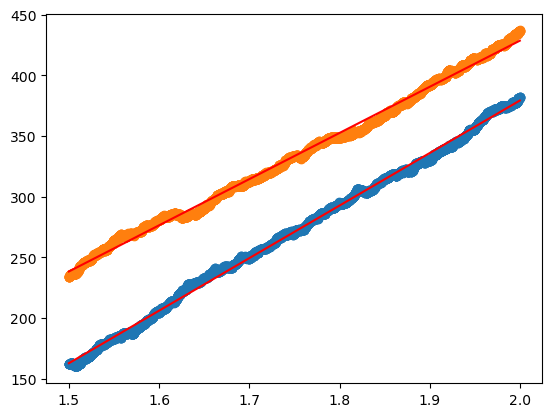

getting equilibrium trajs
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270


In [24]:
n_beads, k, sig_LJ, eps_LJ = 20, 5.0, 1.0, 40.
r_cusp = 2.5
dt = 1*10**-4
@jit(nopython=True)
def Fp(y):
    Fb = np.zeros((n_beads,3))
    Fb[0] = -k*(y[0]-y[1])
#     Fb[0] = [0.,0.,0.]
    for i in range(1, n_beads-1):
        Fb[i] = -k*(2*y[i]-y[i+1]-y[i-1])
    Fb[-1] = -k*(y[-1]-y[-2])
    
    R2 = np.sum((y[-1]-y[0])**2.)
    F_LJ = 4*eps_LJ*(12*sig_LJ**12 / R2**7 - 6*sig_LJ**6 / R2**4)*(y[-1]-y[0])
    
    Fpoly = Fb
    Fpoly[0] = Fpoly[0] - F_LJ
    Fpoly[-1] = Fpoly[-1] + F_LJ
    return Fpoly

@jit(nopython=True)
def trajpoly(seed):
    rmin = 2**(1/6)*sig_LJ
    np.random.seed(seed)
    stepsp = 2*10**6
    y  = np.zeros((n_beads, 3))
    yt = np.zeros((stepsp,n_beads, 3 ))
    r = np.zeros(stepsp)
    for i in range(int(n_beads/2)):
        y[i] = [0.,0.,i*rmin*1.1]
        y[-i] = [rmin, rmin, i*rmin*1.1]
    for i in range(stepsp):
        yt[i] = y
        Fpoly = Fp(y)
        noise = np.random.randn(n_beads,3)
        y = y + dt*Fpoly*mu +  (2*2.*dt)**.5*noise
        yt[i] = yt[i] 
        
#         yt[i] - np.mean(yt[i], axis=0)
        
    return yt
  
# yt = trajpoly(10193)

     
@jit(nopython=True)
def linear_interpolation(x1, y1, x2, y2, x_interpolate):

    # Calculate the slope of the line passing through the two points
    slope = (y2 - y1) / (x2 - x1)
    
    # Calculate the y-intercept of the line
    intercept = y1 - slope * x1
    
    # Calculate the interpolated y value using the equation of the line
    y_interpolate = slope * x_interpolate + intercept
    
    return y_interpolate

@jit(nopython=True)
def traj(v,Fmoltab,xtab, y0, seed):
    rmin = 2**(1/6)*sig_LJ
    dx = xtab[1]-xtab[0]
    np.random.seed(seed)
    x,t = 200,0.
    y  = np.zeros((n_beads, 3))
    yt = np.zeros((steps,n_beads, 3 ))
    y = y0
    trup = 0.
    trig = False
    dt = .0001
    Fmolp = np.zeros((n_beads, 3))
    xt, Fcantt, l, xeq, Fexpmol = np.zeros(steps),np.zeros(steps),np.zeros(steps),np.zeros(steps),np.zeros(steps)
    for i in range(steps):
#         print(i)
        lt = l0 + np.log(1+np.exp(xi*(t-tr)*v))/xi
        Fcant = kcant*(lt-x)
        ind = int(np.floor((x-200)/dx))
#         print(ind, lt)
        x1, y1, x2, y2 = xtab[ind], Fmoltab[ind], xtab[ind+1], Fmoltab[ind+1]
        Fmol = linear_interpolation(x1, y1, x2, y2, x)
        Dxi = 2.
        F = Fcant - Fmol
        xt[i], Fcantt[i], l[i], xeq[i], Fexpmol[i] = x, Fcant, lt, 0., kcant*(lt-x)-kT*v/Dxi
        x = x + dt*F*mu + (2*2.*dt)**.5*np.random.randn()
        
        Fmolp[0], Fmolp[-1] = np.array([0.,0., -Fmol]), np.array([0.,0., Fmol])
#         print(Fp(y))
#         print(Fp(y))
        Fpoly = Fp(y)
#         print(ri)
#         r[i] = (np.sum((y[-1]-y[0])**2.))**.5
        
#         Fpoly, ri = Fpi[0], Fpi[1]
        noise = np.random.randn(n_beads,3)
        y = y + dt*(Fpoly + Fmolp)*mu +  (2*2.*dt)**.5*noise
        yt[i] = y
        r = np.sum((y[-1]-y[0])**2.)**.5
        if r > 3*rmin and trig == False:
            trig = True
            trup = t

        t += dt
     
        
    return np.asarray(xt), np.asarray(Fcantt), np.asarray(l),np.asarray(xeq), np.asarray(Fexpmol), trup, yt


@jit(nopython=True)
def traj_trup(v,Fmoltab,xtab,y0, seed):
    rmin = 2**(1/6)*sig_LJ
    dx = xtab[1]-xtab[0]
    np.random.seed(seed)
    x,t = 200,0.
    kM = 100.
    y = 0
    trup = 0.
    D0 = 1960 #nm^2/s
    D00 = .392 #(nm/s)
    trig = False
    dt = .0001
    y  = np.zeros((n_beads, 3))
    yt = np.zeros((steps,n_beads, 3 ))
    y = y0
    Fmolp = np.zeros((n_beads, 3))
    for i in range(steps):
        lt = l0 + np.log(1+np.exp(xi*(t-tr)*v))/xi
        Fcant = kcant*(lt-x)
        ind = int(np.floor((x-200)/dx))
        x1, y1, x2, y2 = xtab[ind], Fmoltab[ind], xtab[ind+1], Fmoltab[ind+1]
        Fmol = linear_interpolation(x1, y1, x2, y2, x)
        Dxi = D0 + D00*x 
        Dxi = 2.
        F = Fcant - Fmol

        x = x + dt*F*mu + (2*2.*dt)**.5*np.random.randn()
        
        Fmolp[0], Fmolp[-1] = np.array([0.,0., -Fmol]), np.array([0.,0., Fmol])
        Fpoly = Fp(y)
        noise = np.random.randn(n_beads,3)
        y = y + dt*(Fpoly + Fmolp)*mu +  (2*2.*dt)**.5*noise
        r = np.sum((y[-1]-y[0])**2.)**.5
        if r > 3*rmin and trig == False:
            trig = True
            trup = t
            Frup =  kcant*(lt-x)-kT*v/Dxi
            break

        t += dt
     
        
    return trup, Frup

@jit(nopython=True)
def trajcd(v,lamcd, Fmoltab, xtab,y0, seed):
    rmin = 2**(1/6)*sig_LJ
    dx = xtab[1]-xtab[0]
    np.random.seed(seed)
    x,t = 200,0.
    y = 0
    trig = False
    dt = .0001
    y  = np.zeros((n_beads, 3))
    yt = np.zeros((steps,n_beads, 3 ))
    y = y0
    Fmolp = np.zeros((n_beads, 3))
    xt, Fcantt, l, xeq, Fexpmol, Dx = np.zeros(steps-1),np.zeros(steps-1),np.zeros(steps-1),np.zeros(steps-1),np.zeros(steps-1),np.zeros(steps-1)
    for i in range(steps-1):
        lt = lamcd[i]
        Fcant = kcant*(lt-x)
        ind = int(np.floor((x-200)/dx))
        x1, y1, x2, y2 = xtab[ind], Fmoltab[ind], xtab[ind+1], Fmoltab[ind+1]
        Fmol = linear_interpolation(x1, y1, x2, y2, x)

        Dxi = 2.
        F = Fcant - Fmol
        
        xt[i], Fcantt[i], l[i], xeq[i], Fexpmol[i], Dx[i] = x, Fcant, lt, 0., kcant*(lt-x)-kT*v/Dxi, Dxi
        x = x + dt*F*mu + (2*Dxi*dt)**.5*np.random.randn()

        Fmolp[0], Fmolp[-1] = np.array([0.,0., -Fmol]), np.array([0.,0., Fmol])
        Fpoly = Fp(y)
        noise = np.random.randn(n_beads,3)
        y = y + dt*(Fpoly + Fmolp)*mu +  (2*2.*dt)**.5*noise
        r = np.sum((y[-1]-y[0])**2.)**.5
        if r > 3*rmin and trig == False:
            trig = True
            trup = t
        t += dt
 
    return np.asarray(xt), np.asarray(Fcantt), np.asarray(l),np.asarray(xeq), np.asarray(Fexpmol), np.asarray(Dx), trup


@jit(nopython=True)
def traj_trup_cd(v,lamcd, Fmoltab, xtab,y0, seed):
    rmin = 2**(1/6)*sig_LJ
    dx = xtab[1]-xtab[0]
    np.random.seed(seed)
    x,t = 200,0.
    y = 0
    trig = False
    dt = .0001
    y  = np.zeros((n_beads, 3))
    yt = np.zeros((steps,n_beads, 3 ))
    y = y0
    Fmolp = np.zeros((n_beads, 3))
    for i in range(steps-1):
        lt = lamcd[i]
        Fcant = kcant*(lt-x)
        ind = int(np.floor((x-200)/dx))
        x1, y1, x2, y2 = xtab[ind], Fmoltab[ind], xtab[ind+1], Fmoltab[ind+1]
        Fmol = linear_interpolation(x1, y1, x2, y2, x)

        Dxi = 2.
        F = Fcant - Fmol
        x = x + dt*F*mu + (2*Dxi*dt)**.5*np.random.randn()

        Fmolp[0], Fmolp[-1] = np.array([0.,0., -Fmol]), np.array([0.,0., Fmol])
        Fpoly = Fp(y)
        noise = np.random.randn(n_beads,3)
        y = y + dt*(Fpoly + Fmolp)*mu +  (2*2.*dt)**.5*noise
        r = np.sum((y[-1]-y[0])**2.)**.5
        if r > 3*rmin and trig == False:
            trig = True
            trup = t
            Frup =  kcant*(lt-x)-kT*v/Dxi
            break
            

        t += dt
 
    return trup, Frup


def get_rexo_t0(Fcant, Fcantcd, tt):
    
    # Generate some example data points
    x_data = tt[:-1][-5000:]
    y_data = Fcant[:-1][-5000:]
    
    from scipy.optimize import curve_fit
    def equation(t, rexp, t0):
        return rexp*(t-t0)

    # Fit the equation to the data
    params, covariance = curve_fit(equation, x_data, y_data)

    # Extract the parameters of the fitted equation
    rexp_fit, t0_fit = params
    
    print(rexp_fit, t0_fit)
    # Generate the fitted curve
    y_fit = equation(x_data, rexp_fit, t0_fit)

    # Plot the original data and the fitted curve
    plt.scatter(x_data, y_data, label='Data points')
    plt.plot(x_data, y_fit, color='red', label='Fitted curve')


    # Generate some example data points
    x_data = tt[:-1][-5000:]
    y_data = Fcantcd[:-1][-5000:]

    # Fit the equation to the data
    params, covariance = curve_fit(equation, x_data, y_data)

    # Extract the parameters of the fitted equation
    rexp_fitcd, t0_fitcd = params
    print(rexp_fitcd, t0_fitcd)
    # Generate the fitted curve
    y_fit = equation(x_data, rexp_fitcd, t0_fitcd)

    # Plot the original data and the fitted curve
    plt.scatter(x_data, y_data, label='Data points')
    plt.plot(x_data, y_fit, color='red', label='Fitted curve')
    plt.show()
    
    return rexp_fit, t0_fit, rexp_fitcd, t0_fitcd


v = 100
xcd, Fcantcd, lcd, xeqcd, Fexpmolcd,Dxcd, trupcd = trajcd(v,lamcd,np.asarray(Fmol), xtab, y0tab[-1], np.random.choice(np.arange(19289)))


# y0 = yt[-1]

x, Fcant, l,xeqt, Fexpmol, trup, ytrup = traj(v,np.asarray(Fmol),xtab, y0tab[-1], 63536) 



# # Set up the figure
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# ax.set_xlim([-10, 10])  # Set appropriate limits for x-axis
# ax.set_ylim([-10, 10])  # Set appropriate limits for y-axis
# ax.set_zlim([-10, 10])  # Set appropriate limits for z-axis
# ax.set_xlabel('X Label')
# ax.set_ylabel('Y Label')
# ax.set_zlabel('Z Label')
# ax.set_title('3D Polymer Animation')

# cmap = plt.cm.get_cmap('hsv')
# norm = Normalize(vmin=0, vmax=n_beads-1)

# # Initialize empty plot
# line, = ax.plot([], [], [], lw=2)
# trajectory_rup = ytrup[::100]
# # for i in range(len(trajectory)):
# #     trajectory[i] = trajectory[i] -  np.mean(trajectory[i], axis=0)
# # Function to update the plot for each frame
# # Initialize empty plot
# line = None

# # Function to update the plot for each frame
# def update(frame):
#     global line
#     # Clear previous frame
#     if line:
#         line.remove()

#     # Plot the trajectory for the current frame
#     colors = cmap(norm(np.arange(trajectory_rup.shape[1])))
#     line = ax.scatter(trajectory_rup[frame, :, 0], trajectory_rup[frame, :, 1], trajectory_rup[frame, :, 2], c=colors, s=200, alpha = .5)

#     return line,
# # Create the animation
# anim1 = FuncAnimation(fig, update, frames=len(trajectory_rup), blit=True)

# # Display the animation in the notebook
# HTML(anim1.to_html5_video())
# plt.show()



# plt.plot(np.linspace(0, tf, int(tf/dt)),Fcant,label=r'$F_{cant}$', linewidth=5)
# plt.plot(np.linspace(0, dt*len(Fcantcd), len(Fcantcd)),Fcantcd,label=r'$F^{cd}_{cant}$', linewidth=5)
# plt.plot(np.linspace(0, dt*len(Fexpmolcd), len(Fexpmolcd)),Fexpmolcd,label=r'$F^{exp,cd}_{mol}$', linewidth=5)
# plt.plot(np.linspace(0, dt*len(Feq), len(Feq)),Feq,label=r'$F_{eq}$', linewidth=5)
# plt.axvline(trup)
# # plt.axvline(trupcd)

# # Add labels and title
# plt.xlabel(r'$t$ [ms]', fontsize=20)
# plt.ylabel('Forces [pN]', fontsize=20)

# # Set custom tick positions
# custom_ticks = np.arange(0.0, 2.1, 0.5)
# custom_ticksy = np.arange(0.0, 350, 50)
# plt.xticks(custom_ticks)

# # Set the font size of ticks
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)

# # Show legend with fontsize 15
# plt.legend(fontsize=15)
# plt.show()

# plt.plot(np.linspace(0, dt*len(l), len(l)),l, label=r'$\ell$', linewidth=5)
# plt.plot(np.linspace(0, dt*len(x), len(x)),x, label=r'$x$', linewidth=5)
# plt.plot(np.linspace(0, dt*len(xcd), len(xcd)),xcd, label=r'$x_{cd}$', linewidth=5)
# plt.plot(np.linspace(0.,tf, len(xeq)),xeq, '--', label=r'$x_{eq}$', linewidth=5)
# # Add labels and title
# plt.xlabel(r'$t$ [ms]', fontsize=20)
# plt.ylabel('Distances [nm]', fontsize=20)

# # Set custom tick positions
# custom_ticks = np.arange(0.0, 2.1, 0.5)
# custom_ticksy = np.arange(0.0, 350, 50)
# plt.xticks(custom_ticks)

# # Set the font size of ticks
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)

# # Show legend with fontsize 15
# plt.legend(fontsize=15)
# plt.show()


@jit(nopython=True)
def traj_trup_Feq(Feq,y0, seed):
    np.random.seed(seed)
    rmin = 2**(1/6)*sig_LJ
    y  = np.zeros((n_beads, 3))
    yt = np.zeros((steps,n_beads, 3 ))
    y = y0
    Fmolp = np.zeros((n_beads, 3))
    dt = .0001
    t = 0.
    for i in range(len(Feq)):
        
        Fmol = Feq[i]
        Fmolp[0], Fmolp[-1] = np.array([0.,0., -Fmol]), np.array([0.,0., Fmol])
        Fpoly = Fp(y)
        noise = np.random.randn(n_beads,3)
        y = y + dt*(Fpoly + Fmolp)*mu +  (2*2.*dt)**.5*noise
        r = np.sum((y[-1]-y[0])**2.)**.5
        if r > 3*rmin:
            trup = t
            Frup = Fmol
            break
            

        t += dt
 
    return trup, Frup




def get_trup_tab_Feq(Feq,y0tab,num_trajs = 500):
    trup, F = np.zeros(num_trajs), np.zeros(num_trajs)
    for i in range(num_trajs):
        print(i)
        y0 = y0tab[i]
        seed = np.random.choice(np.arange(1099000))
    #     print(seed)
        trup[i], F[i] = traj_trup_Feq(Feq,y0, seed)
#         print(i,trup[i])
    return trup[np.nonzero(trup)[0]], F[np.nonzero(trup)[0]]


def get_trup_tab(v,Fmoltab, xtab,y0tab,num_trajs = 500):
    truptab, F = np.zeros(num_trajs), np.zeros(num_trajs)
    for i in range(num_trajs):
        y0 = y0tab[i]
        seed = np.random.choice(np.arange(1099000))
    #     print(seed)
        truptab[i], F[i] = traj_trup(v,Fmoltab, xtab,y0,seed)
#         print(i,truptab[i])
    return truptab[np.nonzero(truptab)[0]], F[np.nonzero(truptab)[0]]


def get_trup_tab_cd(v,lamcd,Fmoltab, xtab,y0tab,num_trajs = 500):
    trupcd, F = np.zeros(num_trajs), np.zeros(num_trajs)
    for i in range(num_trajs):
        print(i)
        y0 = y0tab[i]
        seed = np.random.choice(np.arange(1099000))
    #     print(seed)
        trupcd[i], F[i] = traj_trup_cd(v,lamcd,Fmoltab, xtab,y0, seed)
#         print(i,trupcd[i])
    return trupcd[np.nonzero(trupcd)[0]], F[np.nonzero(trupcd)[0]]



def do_exps(vtab, y0tab,numtrajs = 1):
    
#     print('Equilibrium rate')
#     ttab0 = np.zeros(numtrajs)
#     for i in range(numtrajs):
#         ttab0[i] = trajk0(0,np.random.choice(np.arange(23939)))
#     lnk0, d = np.log(1/np.mean(ttab0)), .5
    
    trup, trupcd,F, Fcd, rtab, t0tab, rcdtab, t0cdtab = [], [], [], [], [], [], [], []
    trupeq,Frup_eq = [], [] 
    for v in vtab:
        print('v = ',v)
        tt =np.linspace(0, tf, steps)
        
        x, Fcant, l,xeq,Fexpmol,trupv,yt = traj(v,np.asarray(Fmol), xtab,y0tab[-1],np.random.choice(np.arange(349348383)))
        print('Regular pulling')
        ti, Fi = get_trup_tab(v,np.asarray(Fmol), xtab,y0tab,numtrajs)
        trup.append(ti)
        F.append(Fi)
        
        
       
        print('CD pulling')
#         xeq = np.genfromtxt('xeq.csv', delimiter=',')
        lamcd = np.genfromtxt('lamcdtab_'+str(int(v))+'..csv', delimiter=',')[:,1]
        
        ti, Fi = get_trup_tab_cd(v,lamcd,np.asarray(Fmol), xtab,y0tab, numtrajs)
        trupcd.append(ti)
        Fcd.append(Fi)
        
        xcd, Fcantcd, lcd,xeqcd,Fexpmolcd,Dx,t = trajcd(v,lamcd,np.asarray(Fmol), xtab,y0tab[-1], np.random.choice(np.arange(23939)))
        
#         fitting r and t0
        r, t0, rcd, t0cd = get_rexo_t0(Fexpmol, Fexpmolcd, tt)
#         r, t0, rcd, t0cd = get_rexo_t0(Fcant, Fcantcd, tt)
        rtab.append(r)
        t0tab.append(t0)
        rcdtab.append(rcd)
        t0cdtab.append(t0cd)
        
        Feq = np.genfromtxt('Feq_'+str(int(v))+'..csv', delimiter=',')[:,1]
        
        print('getting equilibrium trajs')
        ti, Fi = get_trup_tab_Feq(Feq,y0tab, numtrajs)
        trupeq.append(ti)
        Frup_eq.append(Fi)
        
        
    
    return trup,trupcd, rtab, t0tab, rcdtab, t0cdtab, F,  Fcd,trupeq, Frup_eq
    
vtab = [ 95,100,105, 110,115, 120,125, 130,135, 140,145, 150, 155,160,165]

# vtab = [  160]
trup, trupcd, rtab, t0tab, rcdtab, t0cdtab, F, Fcd, trupeq, Frup_eq = do_exps(vtab,y0tab, numtrajs = 1000)








95


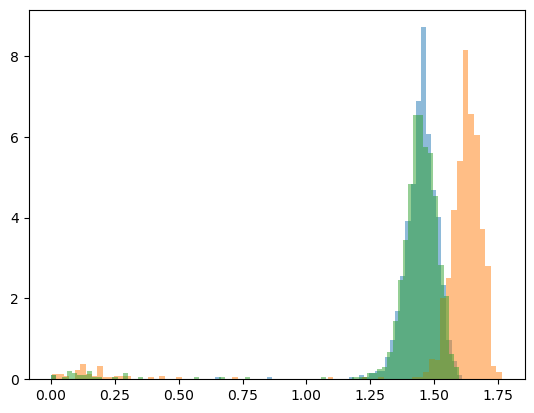

100


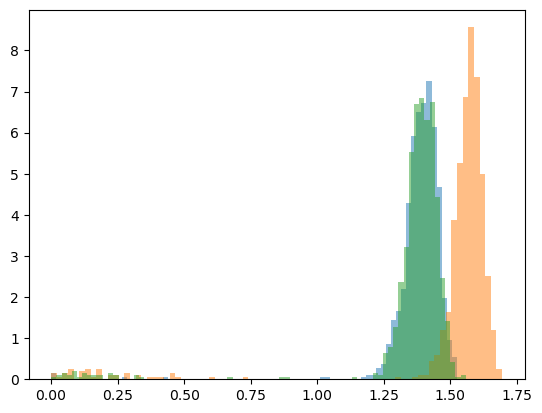

105


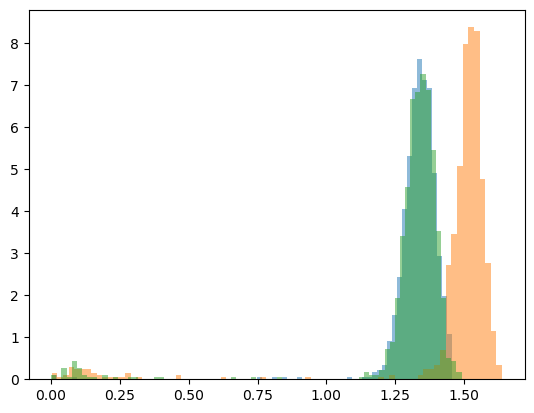

110


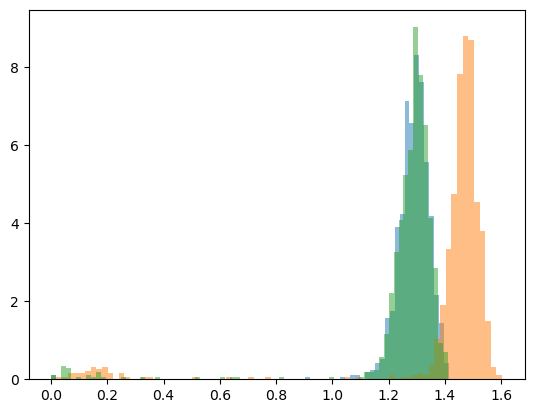

115


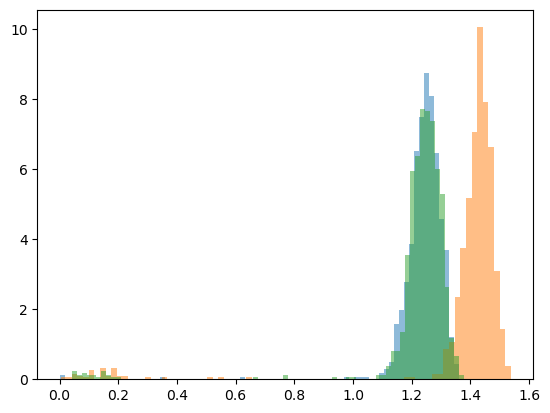

120


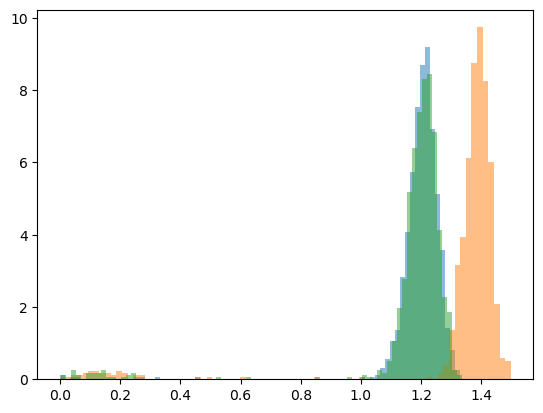

125


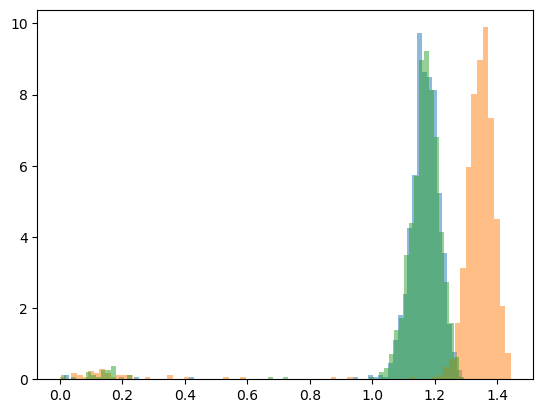

130


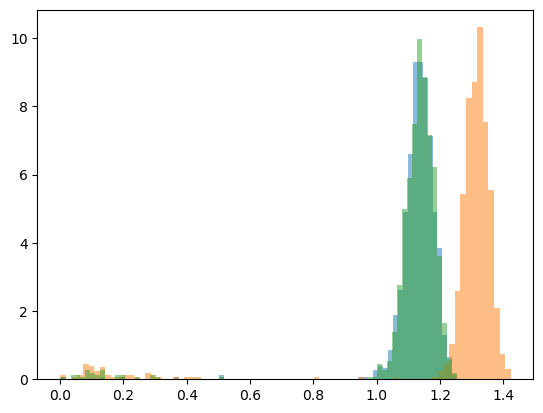

135


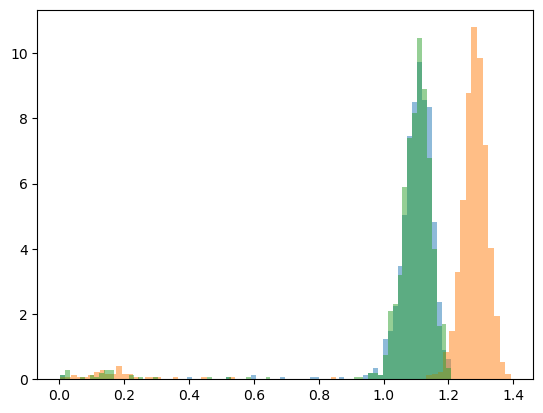

140


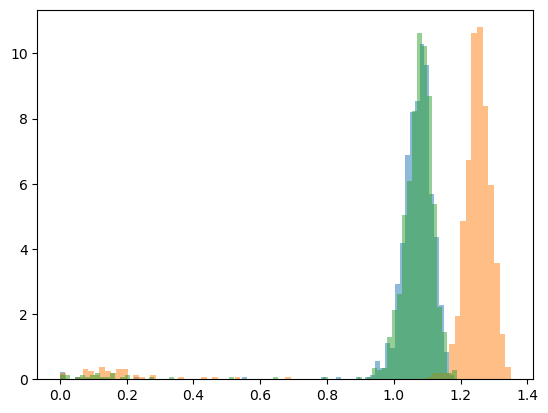

145


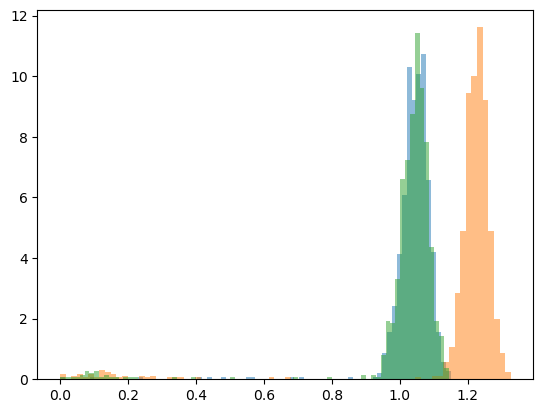

150


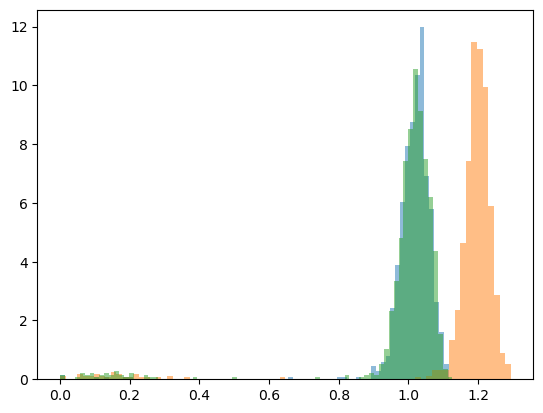

155


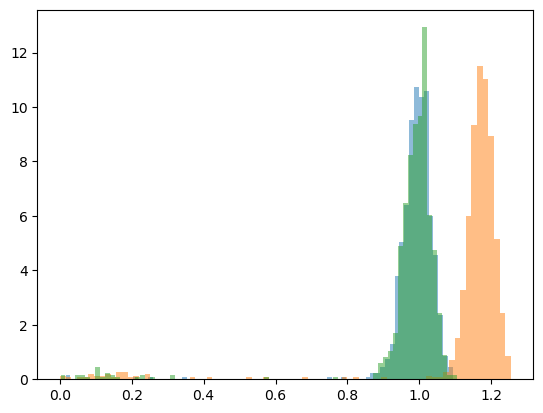

160


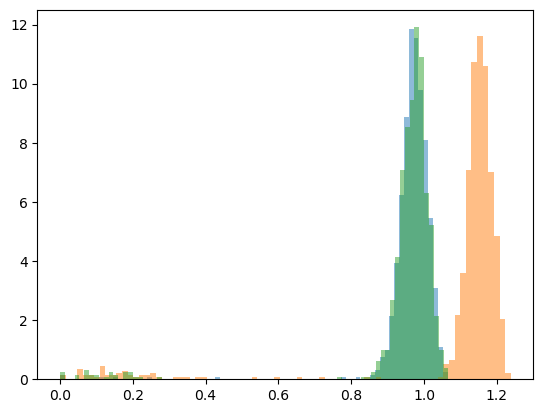

165


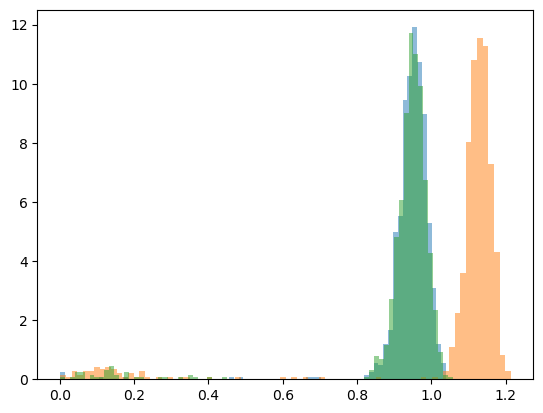

In [25]:
for i in range(len(trupeq)):
    print(vtab[i])
    plt.hist(trupeq[i][np.nonzero(trupeq[i])],80, alpha = .5, density = True)
    plt.hist( trup[i][np.nonzero(trup[i])],80, alpha = .5, density = True)
    plt.hist(trupcd[i][np.nonzero(trupcd[i])],80, alpha = .5, density = True)
#     plt.xlim(1.,2.)
    # plt.ylim(0.,5.)
    plt.show()

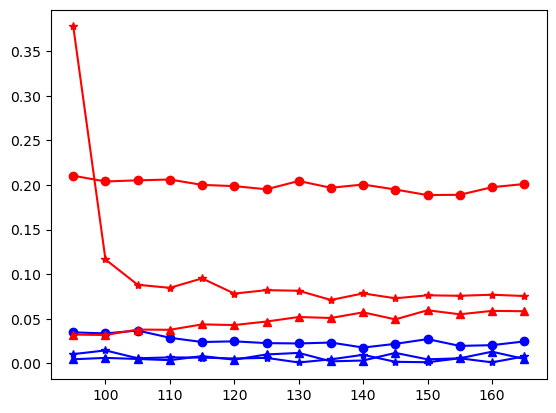

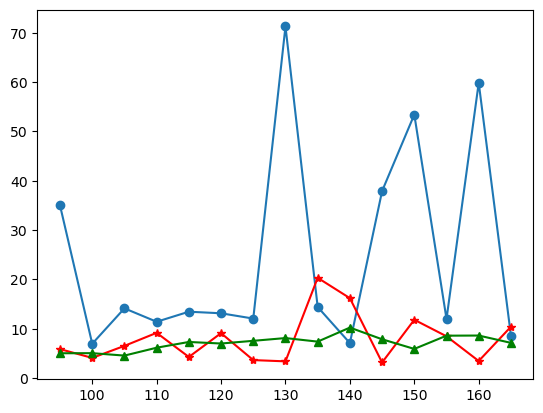

In [34]:
from scipy.stats import wasserstein_distance
dtrup, dtrupcd = [],[]
# Iterate over each subarray in trup, trupcd, and trupeq
for subarray_trup, subarray_trupcd, subarray_trupeq in zip(trup, trupcd, trupeq):
    # Calculate Wasserstein distance between trup and trupeq
    dtrup.append(wasserstein_distance(subarray_trup, subarray_trupeq))

    # Calculate Wasserstein distance between trupcd and trupeq
    dtrupcd.append( wasserstein_distance(subarray_trupcd, subarray_trupeq))

plt.plot(vtab, dtrup,'o-', color = 'r')    
plt.plot(vtab, dtrupcd,'o-', color ='b') 

np.save('dtrup_poly', dtrup)
np.save('dtrupcd_poly', dtrupcd)

dtrup = np.load('dtrup_dhz.npy')
dtrupcd = np.load('dtrupcd_dhz.npy')
plt.plot(vtab, dtrup,'*-', color ='r')    
plt.plot(vtab, dtrupcd,'*-',color = 'b') 

dtrup = np.load('dtrup_cb.npy')
dtrupcd = np.load('dtrupcd_cb.npy')
plt.plot(vtab, dtrup,'^-', color ='r')    
plt.plot(vtab, dtrupcd,'^-', color ='b') 


plt.show()
dtrup = np.load('dtrup_dhz.npy')
dtrupcd = np.load('dtrupcd_dhz.npy')
plt.plot(vtab, (dtrup-dtrupcd)/dtrupcd,'o-', color ='C0')
dtrup = np.load('dtrup_cb.npy')
dtrupcd = np.load('dtrupcd_cb.npy')
plt.plot(vtab, (dtrup-dtrupcd)/dtrupcd,'*-', color ='r')
dtrup = np.load('dtrup_poly.npy')
dtrupcd = np.load('dtrupcd_poly.npy')
plt.plot(vtab, (dtrup-dtrupcd)/dtrupcd,'^-', color ='green')


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

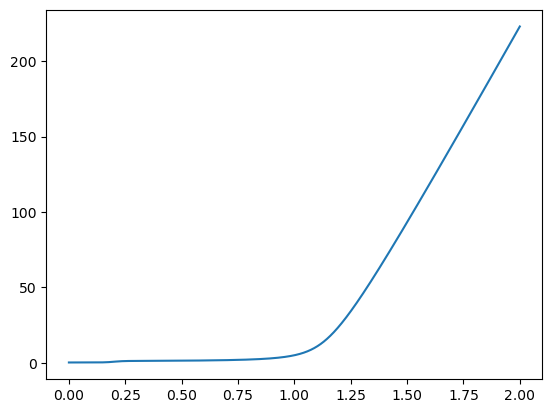

In [9]:
Feq = np.genfromtxt('Feq.csv', delimiter=',')[:,1]
plt.plot(np.linspace(0,2.,len(Feq)),Feq)

@jit(nopython=True)
def traj_trup_Feq(Feq,y0, seed):
    np.random.seed(seed)
    rmin = 2**(1/6)*sig_LJ
    y  = np.zeros((n_beads, 3))
    yt = np.zeros((steps,n_beads, 3 ))
    y = y0
    Fmolp = np.zeros((n_beads, 3))
    dt = .0001
    t = 0.
    for i in range(len(Feq)):
        
        Fmol = Feq[i]
        Fmolp[0], Fmolp[-1] = np.array([0.,0., -Fmol]), np.array([0.,0., Fmol])
        Fpoly = Fp(y)
        noise = np.random.randn(n_beads,3)
        y = y + dt*(Fpoly + Fmolp)*mu +  (2*2.*dt)**.5*noise
        r = np.sum((y[-1]-y[0])**2.)**.5
        if r > 3*rmin:
            trup = t
            Frup = Fmol
            break
            

        t += dt
 
    return trup, Frup




def get_trup_tab_Feq(Feq,y0tab,num_trajs = 500):
    trup, F = np.zeros(num_trajs), np.zeros(num_trajs)
    for i in range(num_trajs):
        print(i)
        y0 = y0tab[i]
        seed = np.random.choice(np.arange(1099000))
    #     print(seed)
        trup[i], F[i] = traj_trup_Feq(Feq,y0, seed)
#         print(i,trup[i])
    return trup[np.nonzero(trup)[0]], F[np.nonzero(trup)[0]]
trupeq, Frup_eq = [],[]
ti, Fi = get_trup_tab_Feq(Feq,y0tab, num_trajs = 1000)
trupeq.append(ti)
Frup_eq.append(Fi)


/var/folders/q4/4wgv01t53ss2w3btpzzlgb6h0000gn/T/ipykernel_90370/1138558156.py:26: RuntimeWarning: overflow encountered in exp
  log_likelihood += np.sum(logk0 + np.log(beta/r) + beta*F*d + np.exp(logk0)/(r*d)*(1-np.exp(beta*F*d)))
/var/folders/q4/4wgv01t53ss2w3btpzzlgb6h0000gn/T/ipykernel_90370/1138558156.py:26: RuntimeWarning: overflow encountered in multiply
  log_likelihood += np.sum(logk0 + np.log(beta/r) + beta*F*d + np.exp(logk0)/(r*d)*(1-np.exp(beta*F*d)))
/Users/benkuznets-speck/miniconda3/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/benkuznets-speck/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Parameters: 4.377388737932597e-05 1.1674814830638898 0.43773887379325965 1.0896962209408267
Parameters: 3.557887525864388e-05 1.8898977373537509 0.3557887525864388 1.112201946305051


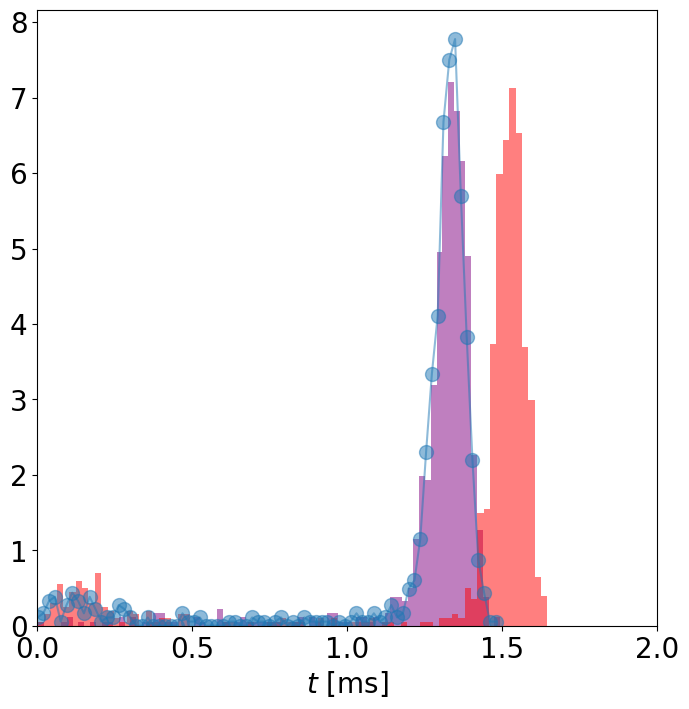

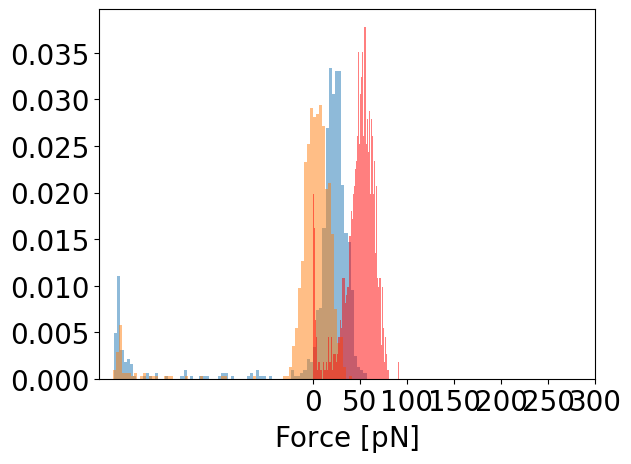

In [27]:


def fit_pt(F, t, r, t0, k0_est, initial_params):

    def likelihood(params, F):

        logk0,d = params
        beta = 1/4.1
        log_likelihood = 0

        log_likelihood += np.sum(logk0  + beta*F*d + np.exp(logk0)*(1-np.exp(beta*F*d))/(r*d))
        return -log_likelihood

    result = minimize(likelihood, initial_params, args=(F,),bounds = [(None,  None ),(None, None)], tol=1e-10)
    logk0,d = result.x
    print("Parameters:", np.exp(logk0),d, np.exp(logk0)/k0_est, logk0/np.log(k0_est))
    
    return  logk0,d

def fit_pt(t, r, t0, k0_est, initial_params):

    def likelihood(params, t):

        logk0,d = params
        beta = 1/4.1
        log_likelihood = 0
        F = r*(t-t0)
        log_likelihood += np.sum(logk0 + np.log(beta/r) + beta*F*d + np.exp(logk0)/(r*d)*(1-np.exp(beta*F*d)))
        return -log_likelihood

    result = minimize(likelihood, initial_params, args=(t,),bounds = [(None,  None ),(None, None)], tol=1e-10)
    logk0,d = result.x
    print("Parameters:", np.exp(logk0),d, np.exp(logk0)/k0_est, logk0/np.log(k0_est))
    
    return  logk0,d

# def plot_ptcd(k0, d,t):
#     r, t0 = rcdtab[0], 1.1
#     beta = 1/4.1
#     pt = k0*np.exp(beta*r*(t-t0)*d + k0/(beta*r*d)*(1-np.exp(beta*r*(t-t0)*d)))
#     plt.plot(t, pt)
#     return pt
# def plot_pt(k0, d,t):
#     r, t0 = rtab[0], .75
#     beta = 1/4.1
#     pt = k0*np.exp(beta*r*(t-t0)*d + k0/(beta*r*d)*(1-np.exp(beta*r*(t-t0)*d)))
#     plt.plot(t, pt)
#     return pt

# mini, maxi = 1, 2
# k0_est = 0.004008016032064128
initial_params  = [-10, 6. ]
logk0,d = fit_pt(trup[0], rtab[0], t0tab[0], k0, initial_params)
# plot_pt(np.exp(logk0), d,np.linspace(0.,2.,1000))
logk0,d = fit_pt(trupcd[0],rcdtab[0], t0cdtab[0] , k0, initial_params)
# plot_ptcd(np.exp(logk0), d,np.linspace(0.,2.,1000))


# logk0,d = fit_pt(F[0], trup[0], rtab[0], t0tab[0], k0, initial_params)
# logk0,d = fit_pt(Fcd[0], trupcd[0], rcdtab[0], t0cdtab[0], k0, initial_params)


plt.figure(figsize=(8, 8))
data = trupcd[0][np.nonzero(trupcd[0])]

# Compute histogram
hist, bins = np.histogram(data, bins=80, density=True)

# Plot histogram values against bin edges as points
plt.plot(bins[:-1], hist, marker='o', linestyle='-', alpha=0.5, ms = 10, label=r'$p^{cd}_{rup}$')

plt.hist(trupeq[0][np.nonzero(trupeq[0])],80, alpha = .5, density = True, color = 'purple', label=r'$p^{eq}_{rup}$', linewidth=5)
plt.hist( trup[0][np.nonzero(trup[0])],80, alpha = .5, density = True, color = 'red', label=r'$p_{rup}$')
# Add labels and title
plt.xlim(0.,2.)

plt.xlabel(r'$t$ [ms]', fontsize=20)
# plt.ylabel('Distances [nm]', fontsize=20)

# Set custom tick positions
custom_ticks = np.arange(0.0, 2.1, 0.5)
# custom_ticksy = np.arange(0.0, 350, 50)
plt.xticks(custom_ticks)

# Set the font size of ticks
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Show legend with fontsize 15
# plt.legend(fontsize=15,frameon=False)
plt.savefig('fig2b.pdf', bbox_inches='tight')
plt.show()

# Show plot
plt.show()



plt.hist(F[0],80, alpha = .5, density = True, label=r'$F^{cd}_{rup}$', linewidth=5)
plt.hist(Fcd[0],80, alpha = .5, density = True, label=r'$F^{cd}_{rup}$', linewidth=5)
plt.hist(Frup_eq[0],80, alpha = .5,color = 'r', density = True, label=r'$F^{eq}_{rup}$', linewidth=5)
# plt.xlim(0.,2.)
plt.xlabel(r'$\mathrm{Force}$ [pN]', fontsize=20)
# plt.ylabel('Distances [nm]', fontsize=20)

# Set custom tick positions
custom_ticks = np.arange(0.0, 300.1, 50)
# custom_ticksy = np.arange(0.0, 350, 50)
plt.xticks(custom_ticks)

# Set the font size of ticks
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Show legend with fontsize 15
# plt.legend(fontsize=20)
# plt.savefig('fig2b.pdf', bbox_inches='tight')
plt.show()


In [167]:
ytrup

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

/var/folders/q4/4wgv01t53ss2w3btpzzlgb6h0000gn/T/ipykernel_90370/1920677057.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm')


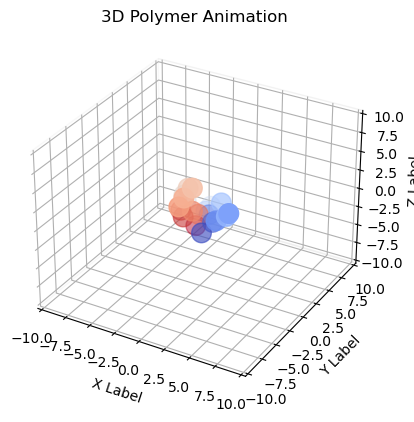

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib.colors import Normalize

# Set up the figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.set_xlim([-10, 10])  # Set appropriate limits for x-axis
ax.set_ylim([-10, 10])  # Set appropriate limits for y-axis
ax.set_zlim([-10, 10])  # Set appropriate limits for z-axis
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_title('3D Polymer Animation')


cmap = plt.cm.get_cmap('coolwarm')
norm = Normalize(vmin=0, vmax=n_beads-1)
trajectory  = y0tab[:100]
# Initialize empty plot
line, = ax.plot([], [], [], lw=2)
# # trajectory = yt[::10000]
for i in range(len(trajectory)):
    trajectory[i] = trajectory[i] -  np.mean(trajectory[i], axis=0)
# Function to update the plot for each frame
# Initialize empty plot
line = None

# Function to update the plot for each frame
def update(frame):
    global line
    # Clear previous frame
    if line:
        line.remove()

    # Plot the trajectory for the current frame
    colors = cmap(norm(np.arange(trajectory.shape[1])))
    line = ax.scatter(trajectory[frame, :, 0], trajectory[frame, :, 1], trajectory[frame, :, 2], c=colors, s=200)

    return line,
# Create the animation
anim = FuncAnimation(fig, update, frames=len(trajectory), blit=True)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
# Display the animation in the notebook
HTML(anim.to_html5_video())


In [26]:
def save_xyz_trajectory(filename, trajectory):
    with open(filename, 'w') as f:
        for timestep in trajectory:
            f.write(f"{len(timestep)}\n")
            f.write("Generated by Python\n")
            for atom_position in timestep:
                f.write(f"X {atom_position[0]:.6f} {atom_position[1]:.6f} {atom_position[2]:.6f}\n")

# Save the trajectory as a .xyz file
save_xyz_trajectory("trajectory.xyz", y0tab)

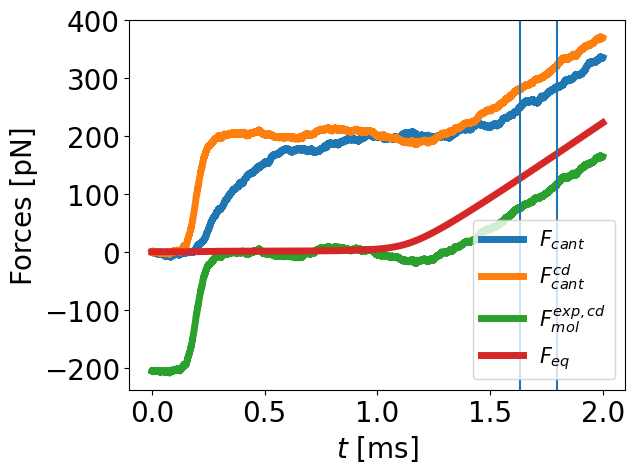

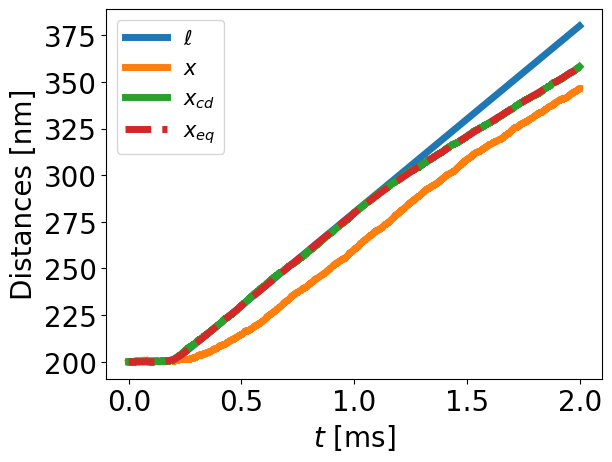

Regular pulling
CD pulling
217.29797942876527 1.4278991420242502
248.83997636045723 1.3599850483463487


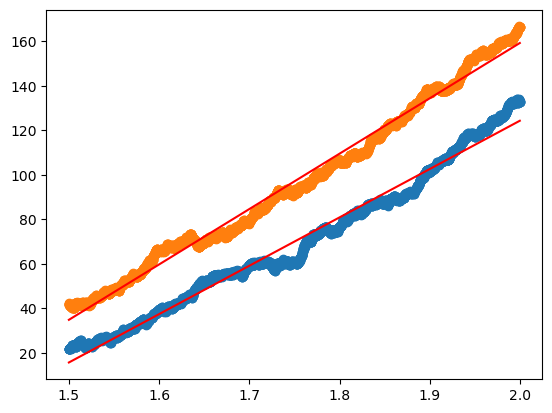

In [804]:
from numba import jit
@jit(nopython=True)
def linear_interpolation(x1, y1, x2, y2, x_interpolate):

    # Calculate the slope of the line passing through the two points
    slope = (y2 - y1) / (x2 - x1)
    
    # Calculate the y-intercept of the line
    intercept = y1 - slope * x1
    
    # Calculate the interpolated y value using the equation of the line
    y_interpolate = slope * x_interpolate + intercept
    
    return y_interpolate






@jit(nopython=True)
def traj(v,Fmoltab,xtab, seed):
    dx = xtab[1]-xtab[0]
    np.random.seed(seed)
#     print('seed = ', seed)
    x,t = 200,0.
    kM = 100.
    y = 0
    trup = 0.
    D0 = 1960 #nm^2/s
    D00 = .392 #(nm/s)
    trig = False
    dt = .0001
    xt, Fcantt, l, xeq, Fexpmol, Dx = np.zeros(steps),np.zeros(steps),np.zeros(steps),np.zeros(steps),np.zeros(steps),np.zeros(steps)
    for i in range(steps):
        lt = l0 + np.log(1+np.exp(xi*(t-tr)*v))/xi
        Fcant = kcant*(lt-x)
        ind = int(np.floor((x-200)/dx))
#         print(ind, lt)
        x1, y1, x2, y2 = xtab[ind], Fmoltab[ind], xtab[ind+1], Fmoltab[ind+1]
        Fmol = linear_interpolation(x1, y1, x2, y2, x)
#         print(Fmol, dx, Fcant)
        Dxi = D0 + D00*x 
        Dxi = 2.
#         Dxi = 1.
        F = Fcant - Fmol
#         print(x, Fcant, lt, 0., kcant*(lt-x)-kT*v/Dxi, Dxi)
        xt[i], Fcantt[i], l[i], xeq[i], Fexpmol[i], Dx[i] = x, Fcant, lt, 0., kcant*(lt-x)-kT*v/Dxi, Dxi
        x = x + dt*F*mu + (2*2.*dt)**.5*np.random.randn()

        kF = k0*np.exp(beta*Fmol*d) 
        if dt*kF > np.random.rand() and trig == False:
            trig = True
            trup = t

        t += dt
     
        
    return np.asarray(xt), np.asarray(Fcantt), np.asarray(l),np.asarray(xeq), np.asarray(Fexpmol), trup


@jit(nopython=True)
def traj_trup(v,Fmoltab,xtab, seed):
    dx = xtab[1]-xtab[0]
    np.random.seed(seed)
#     print('seed = ', seed)
    x,t = 200,0.
    kM = 100.
    y = 0
    trup = 0.
    D0 = 1960 #nm^2/s
    D00 = .392 #(nm/s)
    trig = False
    dt = .0001
#     xt, Fcantt, l, xeq, Fexpmol, Dx = np.zeros(steps),np.zeros(steps),np.zeros(steps),np.zeros(steps),np.zeros(steps),np.zeros(steps)
    for i in range(steps):
        lt = l0 + np.log(1+np.exp(xi*(t-tr)*v))/xi
        Fcant = kcant*(lt-x)
        ind = int(np.floor((x-200)/dx))
#         print(ind, lt)
        x1, y1, x2, y2 = xtab[ind], Fmoltab[ind], xtab[ind+1], Fmoltab[ind+1]
        Fmol = linear_interpolation(x1, y1, x2, y2, x)
#         print(Fmol, dx, Fcant)
        Dxi = D0 + D00*x 
        Dxi = 2.
#         Dxi = 1.
        F = Fcant - Fmol
#         print(x, Fcant, lt, 0., kcant*(lt-x)-kT*v/Dxi, Dxi)
#         xt[i], Fcantt[i], l[i], xeq[i], Fexpmol[i], Dx[i] = x, Fcant, lt, 0., kcant*(lt-x)-kT*v/Dxi, Dxi
        x = x + dt*F*mu + (2*2.*dt)**.5*np.random.randn()

        kF = k0*np.exp(beta*Fmol*d) 
        if dt*kF > np.random.rand() and trig == False:
            trig = True
            trup = t
            Frup =  kcant*(lt-x)-kT*v/Dxi
            break

        t += dt
     
        
    return trup, Frup

x, Fcant, l, xeqi, Fexpmol, trup = traj(v,np.asarray(Fmol), xtab, 3836)


# plt.plot(Fexpmol)
# plt.show()


@jit(nopython=True)
def trajcd(v,lamcd, Fmoltab, xtab, seed):
    dx = xtab[1]-xtab[0]
    np.random.seed(seed)
    x,t = 200,0.
    y = 0
    trig = False
    dt = .0001
    xt, Fcantt, l, xeq, Fexpmol, Dx = np.zeros(steps-1),np.zeros(steps-1),np.zeros(steps-1),np.zeros(steps-1),np.zeros(steps-1),np.zeros(steps-1)
    for i in range(steps-1):
        lt = lamcd[i]
        Fcant = kcant*(lt-x)
        ind = int(np.floor((x-200)/dx))
        x1, y1, x2, y2 = xtab[ind], Fmoltab[ind], xtab[ind+1], Fmoltab[ind+1]
        Fmol = linear_interpolation(x1, y1, x2, y2, x)

        Dxi = 2.
        F = Fcant - Fmol
        
        xt[i], Fcantt[i], l[i], xeq[i], Fexpmol[i], Dx[i] = x, Fcant, lt, 0., kcant*(lt-x)-kT*v/Dxi, Dxi
        x = x + dt*F*mu + (2*Dxi*dt)**.5*np.random.randn()

        kF = k0*np.exp(beta*Fmol*d) 
        if dt*kF > np.random.rand() and trig == False:
            trig = True
            trup = t
            

        t += dt
 
    return np.asarray(xt), np.asarray(Fcantt), np.asarray(l),np.asarray(xeq), np.asarray(Fexpmol), np.asarray(Dx), trup


@jit(nopython=True)
def traj_trup_cd(v,lamcd, Fmoltab, xtab, seed):
    dx = xtab[1]-xtab[0]
    np.random.seed(seed)
    x,t = 200,0.
    y = 0
    trig = False
    dt = .0001
#     xt, Fcantt, l, xeq, Fexpmol, Dx = np.zeros(steps-1),np.zeros(steps-1),np.zeros(steps-1),np.zeros(steps-1),np.zeros(steps-1),np.zeros(steps-1)
    for i in range(steps-1):
        lt = lamcd[i]
        Fcant = kcant*(lt-x)
        ind = int(np.floor((x-200)/dx))
        x1, y1, x2, y2 = xtab[ind], Fmoltab[ind], xtab[ind+1], Fmoltab[ind+1]
        Fmol = linear_interpolation(x1, y1, x2, y2, x)

        Dxi = 2.
        F = Fcant - Fmol
        
#         xt[i], Fcantt[i], l[i], xeq[i], Fexpmol[i], Dx[i] = x, Fcant, lt, 0., kcant*(lt-x)-kT*v/Dxi, Dxi
        x = x + dt*F*mu + (2*Dxi*dt)**.5*np.random.randn()

        kF = k0*np.exp(beta*Fmol*d) 
        if dt*kF > np.random.rand() and trig == False:
            trig = True
            trup = t
            Frup =  kcant*(lt-x)-kT*v/Dxi
            break
            

        t += dt
 
    return trup, Frup


def get_rexo_t0(Fcant, Fcantcd, tt):
    
    # Generate some example data points
    x_data = tt[:-1][-5000:]
    y_data = Fcant[:-1][-5000:]
    
    from scipy.optimize import curve_fit
    def equation(t, rexp, t0):
        return rexp*(t-t0)

    # Fit the equation to the data
    params, covariance = curve_fit(equation, x_data, y_data)

    # Extract the parameters of the fitted equation
    rexp_fit, t0_fit = params
    
    print(rexp_fit, t0_fit)
    # Generate the fitted curve
    y_fit = equation(x_data, rexp_fit, t0_fit)

    # Plot the original data and the fitted curve
    plt.scatter(x_data, y_data, label='Data points')
    plt.plot(x_data, y_fit, color='red', label='Fitted curve')


    # Generate some example data points
    x_data = tt[:-1][-5000:]
    y_data = Fcantcd[:-1][-5000:]

    # Fit the equation to the data
    params, covariance = curve_fit(equation, x_data, y_data)

    # Extract the parameters of the fitted equation
    rexp_fitcd, t0_fitcd = params
    print(rexp_fitcd, t0_fitcd)
    # Generate the fitted curve
    y_fit = equation(x_data, rexp_fitcd, t0_fitcd)

    # Plot the original data and the fitted curve
    plt.scatter(x_data, y_data, label='Data points')
    plt.plot(x_data, y_fit, color='red', label='Fitted curve')
    plt.show()
    
    return rexp_fit, t0_fit, rexp_fitcd, t0_fitcd


xcd, Fcantcd, lcd, xeqcd, Fexpmolcd,Dxcd, trupcd = trajcd(v,lamcd,np.asarray(Fmol), xtab, np.random.choice(np.arange(19289)))

plt.plot(np.linspace(0, tf, int(tf/dt)),Fcant,label=r'$F_{cant}$', linewidth=5)
plt.plot(np.linspace(0, dt*len(Fcantcd), len(Fcantcd)),Fcantcd,label=r'$F^{cd}_{cant}$', linewidth=5)
plt.plot(np.linspace(0, dt*len(Fexpmolcd), len(Fexpmolcd)),Fexpmolcd,label=r'$F^{exp,cd}_{mol}$', linewidth=5)
plt.plot(np.linspace(0, dt*len(Feq), len(Feq)),Feq,label=r'$F_{eq}$', linewidth=5)
plt.axvline(trup)
plt.axvline(trupcd)

# Add labels and title
plt.xlabel(r'$t$ [ms]', fontsize=20)
plt.ylabel('Forces [pN]', fontsize=20)

# Set custom tick positions
custom_ticks = np.arange(0.0, 2.1, 0.5)
custom_ticksy = np.arange(0.0, 350, 50)
plt.xticks(custom_ticks)

# Set the font size of ticks
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Show legend with fontsize 15
plt.legend(fontsize=15)
plt.show()

plt.plot(np.linspace(0, dt*len(l), len(l)),l, label=r'$\ell$', linewidth=5)
plt.plot(np.linspace(0, dt*len(x), len(x)),x, label=r'$x$', linewidth=5)
plt.plot(np.linspace(0, dt*len(xcd), len(xcd)),xcd, label=r'$x_{cd}$', linewidth=5)
plt.plot(np.linspace(0.,tf, len(xeq)),xeq, '--', label=r'$x_{eq}$', linewidth=5)
# Add labels and title
plt.xlabel(r'$t$ [ms]', fontsize=20)
plt.ylabel('Distances [nm]', fontsize=20)

# Set custom tick positions
custom_ticks = np.arange(0.0, 2.1, 0.5)
custom_ticksy = np.arange(0.0, 350, 50)
plt.xticks(custom_ticks)

# Set the font size of ticks
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Show legend with fontsize 15
plt.legend(fontsize=15)
plt.show()


def get_trup_tab(v,Fmoltab, xtab,num_trajs = 500):
    truptab, F = np.zeros(num_trajs), np.zeros(num_trajs)
    for i in range(num_trajs):
    #     print(i)
        seed = np.random.choice(np.arange(1099000))
    #     print(seed)
        truptab[i], F[i] = traj_trup(v,Fmoltab, xtab,seed)
#         print(i,truptab[i])
    return truptab, F


def get_trup_tab_cd(v,lamcd,Fmoltab, xtab,num_trajs = 500):
    trupcd, F = np.zeros(num_trajs), np.zeros(num_trajs)
    for i in range(num_trajs):
    #     print(i)
        seed = np.random.choice(np.arange(1099000))
    #     print(seed)
        trupcd[i], F[i] = traj_trup_cd(v,lamcd,Fmoltab, xtab, seed)
#         print(i,trupcd[i])
    return trupcd, F



def do_exps(vtab, numtrajs = 1):
    
#     print('Equilibrium rate')
#     ttab0 = np.zeros(numtrajs)
#     for i in range(numtrajs):
#         ttab0[i] = trajk0(0,np.random.choice(np.arange(23939)))
#     lnk0, d = np.log(1/np.mean(ttab0)), .5
    
    trup, trupcd,F, Fcd, rtab, t0tab, rcdtab, t0cdtab = [], [], [], [], [], [], [], []
    for v in vtab:
        tt =np.linspace(0, tf, steps)
        
        x, Fcant, l,xeq,Fexpmol,trupv = traj(v,np.asarray(Fmol), xtab,np.random.choice(np.arange(349348383)))
        print('Regular pulling')
        ti, Fi = get_trup_tab(v,np.asarray(Fmol), xtab,numtrajs)
        trup.append(ti)
        F.append(Fi)
        
        
       
        print('CD pulling')
        xeq = np.genfromtxt('xeq.csv', delimiter=',')
        lamcd = np.genfromtxt('lamcdtab.csv', delimiter=',')
        
        ti, Fi = get_trup_tab_cd(v,lamcd,np.asarray(Fmol), xtab, numtrajs)
        trupcd.append(ti)
        Fcd.append(Fi)
        
        xcd, Fcantcd, lcd,xeqcd,Fexpmolcd,Dx,t = trajcd(v,lamcd,np.asarray(Fmol), xtab, np.random.choice(np.arange(23939)))
        
#         fitting r and t0
        r, t0, rcd, t0cd = get_rexo_t0(Fexpmol, Fexpmolcd, tt)
#         r, t0, rcd, t0cd = get_rexo_t0(Fcant, Fcantcd, tt)
        rtab.append(r)
        t0tab.append(t0)
        rcdtab.append(rcd)
        t0cdtab.append(t0cd)
    
    return np.asarray(trup),np.asarray(trupcd), np.asarray(rtab), np.asarray(t0tab), np.asarray(rcdtab), np.asarray(t0cdtab), np.asarray(F),  np.asarray(Fcd)
    

vtab = [100]
trup, trupcd, rtab, t0tab, rcdtab, t0cdtab, F, Fcd = do_exps(vtab, numtrajs = 10000)










Parameters: 0.009674761911477201 0.49145957729518114 96.74761911477201 0.5035899284585018
Parameters: 5.0533708133233806e-05 0.41382503707242924 0.505337081332338 1.0741047080808825


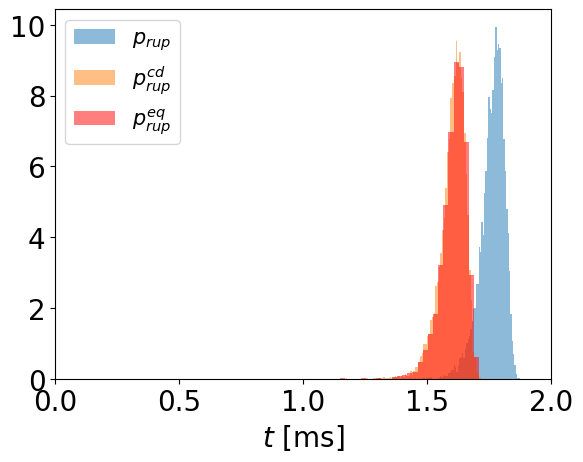

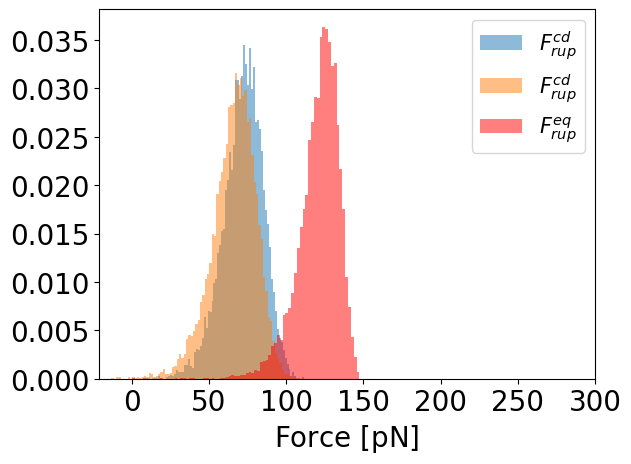

In [805]:


def fit_pt(F, t, r, t0, k0_est, initial_params):

    def likelihood(params, F):

        logk0,d = params
        beta = 1/4.1
        log_likelihood = 0

        log_likelihood += np.sum(logk0  + beta*F*d + np.exp(logk0)*(1-np.exp(beta*F*d))/(r*d))
        return -log_likelihood

    result = minimize(likelihood, initial_params, args=(F,),bounds = [(None,  None ),(None, None)], tol=1e-10)
    logk0,d = result.x
    print("Parameters:", np.exp(logk0),d, np.exp(logk0)/k0_est, logk0/np.log(k0_est))
    
    return  logk0,d

def fit_pt(t, r, t0, k0_est, initial_params):

    def likelihood(params, t):

        logk0,d = params
        beta = 1/4.1
        log_likelihood = 0
        F = r*(t-t0)
        log_likelihood += np.sum(logk0 + np.log(beta/r) + beta*F*d + np.exp(logk0)/(r*d)*(1-np.exp(beta*F*d)))
        return -log_likelihood

    result = minimize(likelihood, initial_params, args=(t,),bounds = [(None,  None ),(None, None)], tol=1e-10)
    logk0,d = result.x
    print("Parameters:", np.exp(logk0),d, np.exp(logk0)/k0_est, logk0/np.log(k0_est))
    
    return  logk0,d

# def plot_ptcd(k0, d,t):
#     r, t0 = rcdtab[0], 1.1
#     beta = 1/4.1
#     pt = k0*np.exp(beta*r*(t-t0)*d + k0/(beta*r*d)*(1-np.exp(beta*r*(t-t0)*d)))
#     plt.plot(t, pt)
#     return pt
# def plot_pt(k0, d,t):
#     r, t0 = rtab[0], .75
#     beta = 1/4.1
#     pt = k0*np.exp(beta*r*(t-t0)*d + k0/(beta*r*d)*(1-np.exp(beta*r*(t-t0)*d)))
#     plt.plot(t, pt)
#     return pt

# mini, maxi = 1, 2
# k0_est = 0.004008016032064128
initial_params  = [-20, .4 ]
logk0,d = fit_pt(trup[0], rtab[0], t0tab[0], k0, initial_params)
# plot_pt(np.exp(logk0), d,np.linspace(0.,2.,1000))
logk0,d = fit_pt(trupcd[0],250,1.05 , k0, initial_params)
# plot_ptcd(np.exp(logk0), d,np.linspace(0.,2.,1000))


# logk0,d = fit_pt(F[0], trup[0], rtab[0], t0tab[0], k0, initial_params)
# logk0,d = fit_pt(Fcd[0], trupcd[0], rcdtab[0], t0cdtab[0], k0, initial_params)


plt.hist(trup[0],80, alpha = .5, density = True, label=r'$p_{rup}$', linewidth=5)
plt.hist(trupcd[0],80, alpha = .5, density = True, label=r'$p^{cd}_{rup}$', linewidth=5)
plt.hist(trupeq[0],80, alpha = .5,color = 'r', density = True, label=r'$p^{eq}_{rup}$', linewidth=5)

# plt.yscale('log')
plt.xlim(0.,2.)
plt.xlabel(r'$t$ [ms]', fontsize=20)
# plt.ylabel('Distances [nm]', fontsize=20)

# Set custom tick positions
custom_ticks = np.arange(0.0, 2.1, 0.5)
# custom_ticksy = np.arange(0.0, 350, 50)
plt.xticks(custom_ticks)

# Set the font size of ticks
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Show legend with fontsize 15
plt.legend(fontsize=15)
plt.show()



plt.hist(F[0],80, alpha = .5, density = True, label=r'$F^{cd}_{rup}$', linewidth=5)
plt.hist(Fcd[0],80, alpha = .5, density = True, label=r'$F^{cd}_{rup}$', linewidth=5)
plt.hist(Frup_eq[0],80, alpha = .5,color = 'r', density = True, label=r'$F^{eq}_{rup}$', linewidth=5)
# plt.xlim(0.,2.)
plt.xlabel(r'$\mathrm{Force}$ [pN]', fontsize=20)
# plt.ylabel('Distances [nm]', fontsize=20)

# Set custom tick positions
custom_ticks = np.arange(0.0, 300.1, 50)
# custom_ticksy = np.arange(0.0, 350, 50)
plt.xticks(custom_ticks)

# Set the font size of ticks
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Show legend with fontsize 15
plt.legend(fontsize=15)
plt.show()


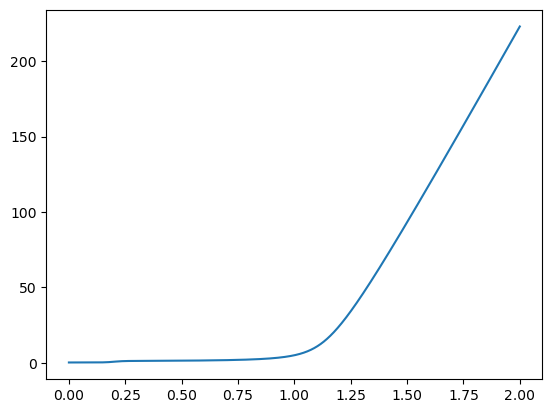

In [177]:
Feq = np.genfromtxt('Feq.csv', delimiter=',')[:,1]
plt.plot(np.linspace(0,2.,len(Feq)),Feq)

@jit(nopython=True)
def traj_trup_Feq(Feq, seed):
    np.random.seed(seed)

    dt = .0001
    t = 0.
#     xt, Fcantt, l, xeq, Fexpmol, Dx = np.zeros(steps-1),np.zeros(steps-1),np.zeros(steps-1),np.zeros(steps-1),np.zeros(steps-1),np.zeros(steps-1)
    for i in range(len(Feq)):
        
        Fmol = Feq[i]
        kF = k0*np.exp(beta*Fmol*d) 
        if dt*kF > np.random.rand():
            trup = t
            Frup = Fmol
            break
            

        t += dt
 
    return trup, Frup

def get_trup_tab_Feq(Feq,num_trajs = 500):
    trup, F = np.zeros(num_trajs), np.zeros(num_trajs)
    for i in range(num_trajs):
    #     print(i)
        seed = np.random.choice(np.arange(1099000))
    #     print(seed)
        trup[i], F[i] = traj_trup_Feq(Feq, seed)
#         print(i,trup[i])
    return trup, F
trupeq, Frup_eq = [],[]
ti, Fi = get_trup_tab_Feq(Feq, num_trajs = 10**4)
trupeq.append(ti)
Frup_eq.append(Fi)



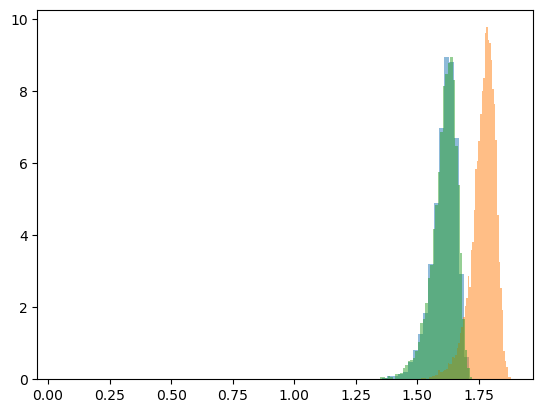

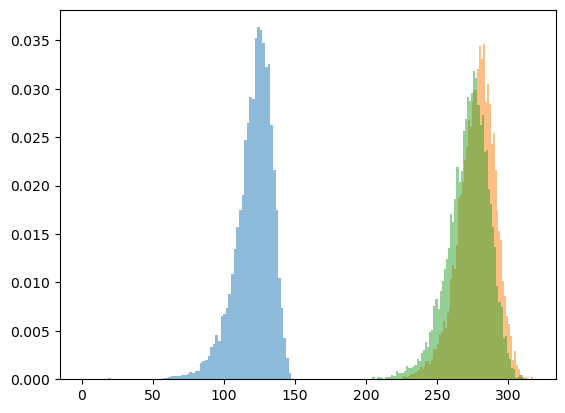

In [766]:
plt.hist(trupeq[0],80, alpha = .5, density = True)
plt.hist(trup[0],80, alpha = .5, density = True)
plt.hist(trupcd[0],80, alpha = .5, density = True)
plt.show()

plt.hist(Frup_eq[0],80, alpha = .5, density = True)
plt.hist(F[0],80, alpha = .5, density = True)
plt.hist(Fcd[0],80, alpha = .5, density = True)
plt.show()
# plt.hist(trupcd[0],80, alpha = .5, density = True)

In [688]:
trupeq

[array([1.4882, 1.7019, 1.6494, ..., 1.583 , 1.6238, 1.6728])]

In [537]:
kcant

10

/var/folders/q4/4wgv01t53ss2w3btpzzlgb6h0000gn/T/ipykernel_78009/3061411341.py:8: RuntimeWarning: overflow encountered in exp
  log_likelihood += np.sum(logk0 + beta*r*(t-t0)*d + np.exp(logk0)/(beta*r*d)*(1-np.exp(beta*r*(t-t0)*d)))
/var/folders/q4/4wgv01t53ss2w3btpzzlgb6h0000gn/T/ipykernel_78009/3061411341.py:8: RuntimeWarning: overflow encountered in multiply
  log_likelihood += np.sum(logk0 + beta*r*(t-t0)*d + np.exp(logk0)/(beta*r*d)*(1-np.exp(beta*r*(t-t0)*d)))
/var/folders/q4/4wgv01t53ss2w3btpzzlgb6h0000gn/T/ipykernel_78009/3061411341.py:8: RuntimeWarning: invalid value encountered in multiply
  log_likelihood += np.sum(logk0 + beta*r*(t-t0)*d + np.exp(logk0)/(beta*r*d)*(1-np.exp(beta*r*(t-t0)*d)))


3.184467000176565 2.7406177306678594


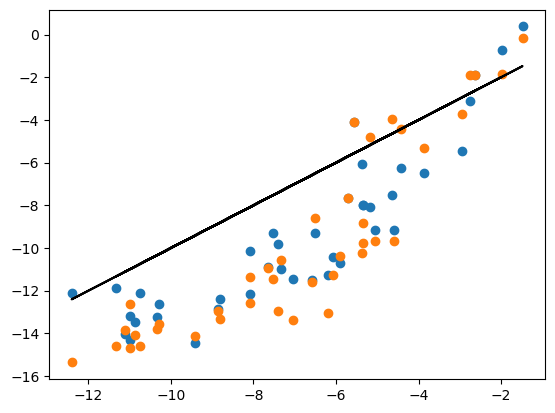

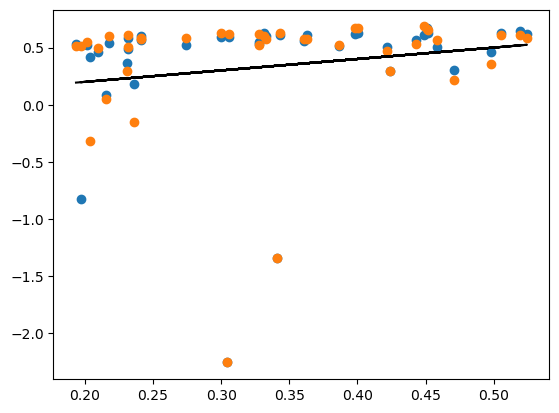

In [145]:
def fit_pt(t, r, t0, k0_est, initial_params):

    def likelihood(params, trup):
    # Compute the likelihood for the given parameters and samples
        logk0,d = params
        beta = 1/4.1
        log_likelihood = 0
        log_likelihood += np.sum(logk0 + beta*r*(t-t0)*d + np.exp(logk0)/(beta*r*d)*(1-np.exp(beta*r*(t-t0)*d)))
        return -log_likelihood

#     result = minimize(likelihood, initial_params, args=(trup,), tol=1e-10)
    result = minimize(likelihood, initial_params, args=(trup,),bounds = [(None, None),(None, None)], tol=1e-10)
    logk0,d = result.x
#     print( result.x)
#     print("Parameters:", np.exp(logk0),d, (np.exp(logk0))/k0_est)
    
    return  logk0,d


import os
import re
import numpy as np

# Directory containing the files
directory = 'data_cd0/'

# Regular expression pattern to extract 'a' and 'b' from file names
pattern = r'lnk0_([\d.]+)_([\d.]+)\.npy'
lnk0, lnk0cd_fit, lnk0_fit, dU, d, dcd_fit, d_fit = [], [], [], [], [], [], []
# Loop through files in the directory
for filename in os.listdir(directory):
    if filename.startswith('lnk0_') and filename.endswith('.npy'):
        # Extract 'a' and 'b' from the file name using regex
        match = re.match(pattern, filename)
        if match:
            a = float(match.group(1))
            b = float(match.group(2))
            dU.append(a)
            d.append(b/2)
#             print(f"File: {filename}, a: {a}, b: {b}")
            # Load the file and assign it to 'lnk0'
            lnk0.append(np.load(os.path.join(directory, filename)))
            trup = np.load('data_cd0/trup_' + str(a) + '_' + str(b)+'.npy')
            trupcd = np.load('data_cd0/trupcd_' + str(a) + '_' + str(b)+'.npy')
            r = np.load('data_cd0/r_' + str(a) + '_' + str(b)+'.npy')
            rcd = np.load('data_cd0/rcd_' + str(a) + '_' + str(b)+'.npy')
            t0 = np.load('data_cd0/t0_' + str(a) + '_' + str(b)+'.npy')
            t0cd = np.load('data_cd0/t0cd_' + str(a) + '_' + str(b)+'.npy')
#             d.append(b)
            
            initial_params = [lnk0[-1]+np.random.randn(),d[-1]+np.random.randn() ]
#             initial_params = [-10, .4]
            logk0cd_fiti,dcd_fiti = fit_pt(trupcd,  rcd, t0cd, np.exp(lnk0[-1]),initial_params)
            lnk0cd_fit.append(logk0cd_fiti)
            dcd_fit.append(dcd_fiti)
            
            logk0_fiti,d_fiti = fit_pt(trup,  r, t0, np.exp(lnk0[-1]),initial_params)
            lnk0_fit.append(logk0_fiti)
            d_fit.append(d_fiti)


lnk0cd_fit, lnk0_fit = np.asarray(lnk0cd_fit), np.asarray(lnk0_fit)
plt.plot(lnk0, lnk0cd_fit,'o')
plt.plot(lnk0, lnk0_fit,'o')
print(np.mean(abs(lnk0 - lnk0_fit)), np.mean(abs(lnk0 - lnk0cd_fit)))
# plt.plot(lnk0, .5*(lnk0cd_fit + lnk0_fit),'o')
plt.plot(lnk0, lnk0, 'k')
plt.show()
plt.plot(d, dcd_fit,'o')
plt.plot(d, d_fit,'o')
plt.plot(d, d, 'k')
plt.show()